In [ ]:
# Сохранение в каталоги фотографий для калибровки
import cv2
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from datetime import datetime
import os

сapL = cv2.VideoCapture(0)
capR = cv2.VideoCapture(1)

сapL.set(cv2.CAP_PROP_FRAME_WIDTH, int(1920))
сapL.set(cv2.CAP_PROP_FRAME_HEIGHT, int(1080))
capR.set(cv2.CAP_PROP_FRAME_WIDTH, int(1920))
capR.set(cv2.CAP_PROP_FRAME_HEIGHT, int(1080))

time.sleep(0.2)

if not os.path.exists('camR'):
  os.mkdir('camR')
if not os.path.exists('camL'):  
  os.mkdir('camL')

num = 0


while True:

    retL, fL = сapL.read()
    retR, fR = capR.read()

    origR = fR.copy()
    origL = fL.copy()

    cv2.imshow('Камера', origR)

    key = cv2.waitKey(1) & 0xFF
 
    if key == ord('q'):  # Выход
        break


    if key == ord('s'):
        cam_idx = 0
        h, w = origR.shape[:2]
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        fname = f"camR\cam_R{num:06d}.png"
        try:
            ok = cv2.imwrite(fname, origR)
            if ok:
                print(f"Saved {fname}")
            else:
                print(f"Failed to save {fname}")
        except Exception as e:
            print(f"Error saving {fname}: {e}")

        cam_idx = 1
        h, w = origL.shape[:2]
        fname = f"camL\cam_L{num:06d}.png"
        try:
            ok = cv2.imwrite(fname, origL)
            if ok:
                print(f"Saved {fname}")
            else:
                print(f"Failed to save {fname}")
        except Exception as e:
            print(f"Error saving {fname}: {e}")

        num = num + 1
    

cv2.destroyAllWindows()

In [38]:
# калибровка по сохраненным изображениям 
import cv2
import numpy as np
import glob
import os

# Параметры шахматной доски
CHECKERBOARD = (9, 6)  # (ширина, высота) — количество внутренних углов
SQUARE_SIZE = 0.00718      # Размер клетки в условных единицах (например, см). Не обязателен для калибровки.

# Критерии для уточнения координат углов
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Подготовка объектов (3D точки в реальном мире)
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * SQUARE_SIZE

# Массивы для хранения точек
objpoints = []  # 3D точки в реальном мире
imgpointsL = []  # 2D точки на левых изображениях
imgpointsR = []  # 2D точки на правых изображениях

# Получаем список файлов (предполагаем одинаковые имена или сортировку по имени)
images_left = sorted(glob.glob('camL/*.jpg') + glob.glob('camL/*.png'))
images_right = sorted(glob.glob('camR/*.jpg') + glob.glob('camR/*.png'))

if len(images_left) != len(images_right):
    raise ValueError("Количество изображений в camL и camR не совпадает!")

print(f"Найдено {len(images_left)} пар изображений.")

for i, (imgL_path, imgR_path) in enumerate(zip(images_left, images_right)):
    print(f"Обработка пары {i+1}/{len(images_left)}: {os.path.basename(imgL_path)}")

    imgL = cv2.imread(imgL_path)
    imgR = cv2.imread(imgR_path)

    if imgL is None or imgR is None:
        print(f"Пропущена пара: {imgL_path}, {imgR_path}")
        continue

    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Найти углы шахматной доски
    retL, cornersL = cv2.findChessboardCorners(grayL, CHECKERBOARD, None)
    retR, cornersR = cv2.findChessboardCorners(grayR, CHECKERBOARD, None)

    if retL and retR:
        objpoints.append(objp)

        # Уточнение координат углов
        cornersL = cv2.cornerSubPix(grayL, cornersL, (11, 11), (-1, -1), criteria)
        cornersR = cv2.cornerSubPix(grayR, cornersR, (11, 11), (-1, -1), criteria)

        imgpointsL.append(cornersL)
        imgpointsR.append(cornersR)

        # Опционально: отобразить найденные углы
        cv2.drawChessboardCorners(imgL, CHECKERBOARD, cornersL, retL)
        cv2.drawChessboardCorners(imgR, CHECKERBOARD, cornersR, retR)
        cv2.imshow('Left', imgL)
        cv2.imshow('Right', imgR)
        cv2.waitKey(500)
    else:
        print(f"Шахматная доска не найдена на одном из изображений в паре {i+1}")

cv2.destroyAllWindows()

if len(objpoints) == 0:
    print("Не найдено ни одной подходящей пары изображений!")
    exit()

# Размер изображения (должен быть одинаковым для всех)
image_size = grayL.shape[::-1]  # (ширина, высота)

# === Калибровка отдельных камер ===
print("Калибровка левой камеры...")
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(
    objpoints, imgpointsL, image_size, None, None
)

print("Калибровка правой камеры...")
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(
    objpoints, imgpointsR, image_size, None, None
)

# === Стерео калибровка ===
print("Стерео калибровка...")
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC  # Использовать матрицы, полученные при моно-калибровке

# Возвращаем: R — поворот между камерами, T — смещение
retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(
    objpoints,
    imgpointsL,
    imgpointsR,
    mtxL,
    distL,
    mtxR,
    distR,
    image_size,
    criteria=criteria,
    flags=flags
)

# === Стерео ректификация ===
print("Вычисление матриц ректификации...")
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    cameraMatrix1,
    distCoeffs1,
    cameraMatrix2,
    distCoeffs2,
    image_size,
    R,
    T,
    alpha=0  # 0 — только действительная область; 1 — вся картинка
)

# Сохранение параметров (опционально)
np.savez('stereo_calibration.npz',
         cameraMatrix1=cameraMatrix1,
         distCoeffs1=distCoeffs1,
         cameraMatrix2=cameraMatrix2,
         distCoeffs2=distCoeffs2,
         R=R, T=T, E=E, F=F,
         R1=R1, R2=R2, P1=P1, P2=P2, Q=Q)

print("✅ Калибровка завершена! Параметры сохранены в 'stereo_calibration.npz'")

Найдено 36 пар изображений.
Обработка пары 1/36: cam_L000000.png
Обработка пары 2/36: cam_L000001.png
Обработка пары 3/36: cam_L000002.png
Обработка пары 4/36: cam_L000003.png
Обработка пары 5/36: cam_L000004.png
Обработка пары 6/36: cam_L000005.png
Обработка пары 7/36: cam_L000006.png
Обработка пары 8/36: cam_L000007.png
Обработка пары 9/36: cam_L000008.png
Обработка пары 10/36: cam_L000009.png
Обработка пары 11/36: cam_L000010.png
Обработка пары 12/36: cam_L000011.png
Обработка пары 13/36: cam_L000012.png
Обработка пары 14/36: cam_L000013.png
Обработка пары 15/36: cam_L000014.png
Обработка пары 16/36: cam_L000015.png
Обработка пары 17/36: cam_L000016.png
Обработка пары 18/36: cam_L000017.png
Обработка пары 19/36: cam_L000018.png
Шахматная доска не найдена на одном из изображений в паре 19
Обработка пары 20/36: cam_L000019.png
Шахматная доска не найдена на одном из изображений в паре 20
Обработка пары 21/36: cam_L000020.png
Обработка пары 22/36: cam_L000021.png
Обработка пары 23/36: c

In [39]:
# Сохранение в каталоги фотографий построение карт глубины - рабочая фотка
import cv2
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from datetime import datetime
import os

сapL = cv2.VideoCapture(0)
capR = cv2.VideoCapture(1)

сapL.set(cv2.CAP_PROP_FRAME_WIDTH, int(1920))
сapL.set(cv2.CAP_PROP_FRAME_HEIGHT, int(1080))
capR.set(cv2.CAP_PROP_FRAME_WIDTH, int(1920))
capR.set(cv2.CAP_PROP_FRAME_HEIGHT, int(1080))

time.sleep(0.2)

if not os.path.exists('stereopair'):
  os.mkdir('stereopair')

num = 0


while True:

    retL, fL = сapL.read()
    retR, fR = capR.read()

    origR = fR.copy()
    origL = fL.copy()

    cv2.imshow('cam for save', origR)

    key = cv2.waitKey(1) & 0xFF
 
    if key == ord('q'):  # Выход
        break


    if key == ord('s'):
        cam_idx = 0
        h, w = origR.shape[:2]
        fname = f"stereopair\imgR.png"
        print(fname)
        try:
            ok = cv2.imwrite(fname, origR)
            if ok:
                print(f"Saved {fname}")
            else:
                print(f"Failed to save {fname}")
        except Exception as e:
            print(f"Error saving {fname}: {e}")

        cam_idx = 1
        h, w = origL.shape[:2]
        fname = f"stereopair\imgL.png"
        try:
            ok = cv2.imwrite(fname, origL)
            if ok:
                print(f"Saved {fname}")
            else:
                print(f"Failed to save {fname}")
        except Exception as e:
            print(f"Error saving {fname}: {e}")

        num = num + 1
    

cv2.destroyAllWindows()

stereopair\imgR.png
Saved stereopair\imgR.png
Saved stereopair\imgL.png


In [45]:
# построение карты глубин для пары изображений из каталога 
import cv2
import numpy as np

# === 1. Загрузка параметров калибровки ===
calib_data = np.load('stereo_calibration.npz')

# Матрицы проекции после ректификации (P1, P2)
P1 = calib_data['P1']
P2 = calib_data['P2']

# Фокусное расстояние (из P1 или cameraMatrix1)
f = P1[0, 0]  # или calib_data['cameraMatrix1'][0, 0]
f = calib_data['cameraMatrix1'][0, 0]

# База (расстояние между камерами)
# Из матрицы проекции P2: P2[0, 3] = -f * B_x => B = -P2[0, 3] / f
B = -P2[0, 3] / f  # в тех же единицах, что и калибровочные объекты (например, см)

print(f"Фокусное расстояние: {f:.2f} px")
print(f"База: {B:.2f} условных единиц")


imgL = cv2.imread('stereopair/imgL.png')
imgR = cv2.imread('stereopair/imgR.png')

h, w = imgL.shape[:2]
image_size = (w, h)


# Извлекаем необходимые матрицы
cameraMatrix1 = calib_data['cameraMatrix1']
distCoeffs1 = calib_data['distCoeffs1']
R1 = calib_data['R1']

cameraMatrix2 = calib_data['cameraMatrix2']
distCoeffs2 = calib_data['distCoeffs2']
R2 = calib_data['R2']

# Генерация карт для remap
map1_l, map2_l = cv2.initUndistortRectifyMap(
    cameraMatrix1, distCoeffs1, R1, P1, image_size, cv2.CV_16SC2
)
map1_r, map2_r = cv2.initUndistortRectifyMap(
    cameraMatrix2, distCoeffs2, R2, P2, image_size, cv2.CV_16SC2
)

# === 3. Загрузка новой пары изображений ===

if imgL is None or imgR is None:
    raise FileNotFoundError("Не удалось загрузить изображения!")

# Преобразуем в grayscale (требуется для stereo matching)
grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# === 4. Ректификация изображений ===
rectifiedL = cv2.remap(grayL, map1_l, map2_l, cv2.INTER_LINEAR)
rectifiedR = cv2.remap(grayR, map1_r, map2_r, cv2.INTER_LINEAR)


#rectifiedL.imwrite('rectified_left.jpg')

# Опционально: показать ректифицированные изображения

scale_percent = 50
width = int(imgL.shape[1] * scale_percent / 100)
height = int(imgR.shape[0] * scale_percent / 100)
dim = (width, height)

resized_imgL = cv2.resize(rectifiedL, dim, interpolation=cv2.INTER_AREA)
resized_imgR = cv2.resize(rectifiedR, dim, interpolation=cv2.INTER_AREA)

cv2.imshow('Rectified Left', resized_imgL )
cv2.imshow('Rectified Right',resized_imgR)
#cv2.waitKey(0)

# === 5. Вычисление disparity map ===
# Используем StereoSGBM (рекомендуется)
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16 * 6,   # должно делиться на 16
    blockSize=11,
    P1=8 * 3 * 11**2,
    P2=32 * 3 * 11**2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=100,
    speckleRange=32
)

disparity = stereo.compute(rectifiedL, rectifiedR).astype(np.float32) / 16.0  # делим на 16 (OpenCV специфика)

# === 6. Преобразование disparity → depth ===
# Избегаем деления на ноль
disparity[disparity <= 0] = 0.001  # минимальное значение

depth_map = (f * B) / disparity  # глубина в тех же единицах, что и B

# === 7. Визуализация ===
# Нормализуем для отображения
disp_vis = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)


resized_disp_vis = cv2.resize(disp_vis, dim, interpolation=cv2.INTER_AREA)
resized_depth_vis= cv2.resize(depth_vis , dim, interpolation=cv2.INTER_AREA)


cv2.imshow('Disparity', resized_disp_vis)
cv2.imshow('Depth', resized_depth_vis)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Сохранить карту глубины (в метрах/см, если B задан правильно)
np.save('depth_map.npy', depth_map)

Фокусное расстояние: 1251.20 px
База: 0.19 условных единиц


In [41]:
# визуализация карты глубин  

import open3d as o3d
import cv2
import numpy as np

# Загрузка данных
depth_map = np.load('depth_map.npy')  # Может быть float64!
Q = np.load('stereo_calibration.npz')['Q']

# === ВАЖНО: привести к float32 ===
if depth_map.dtype != np.float32:
    depth_map = depth_map.astype(np.float32)

# Теперь можно использовать reprojectImageTo3D
points = cv2.reprojectImageTo3D(depth_map, Q)

# Маска для валидных точек (где глубина разумна)
# Например, отсекаем слишком большие значения или нули
mask = (depth_map > 0.0001) & (depth_map < 300000000.0)  # настройте под ваш случай

# Применяем маску
points_valid = points[mask]
# Если у вас есть ректифицированное левое изображение:
rgb_image = cv2.imread('rectified_left.jpg')  # должно быть того же размера, что и depth_map
if rgb_image is not None:
    colors = rgb_image[mask] / 255.0  # нормализуем в [0, 1]
else:
    colors = np.tile([0.5, 0.5, 0.5], (points_valid.shape[0], 1))  # серый цвет по умолчанию

# Создание облака точек
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_valid.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(colors.reshape(-1, 3))

# Визуализация
o3d.visualization.draw_geometries([pcd])

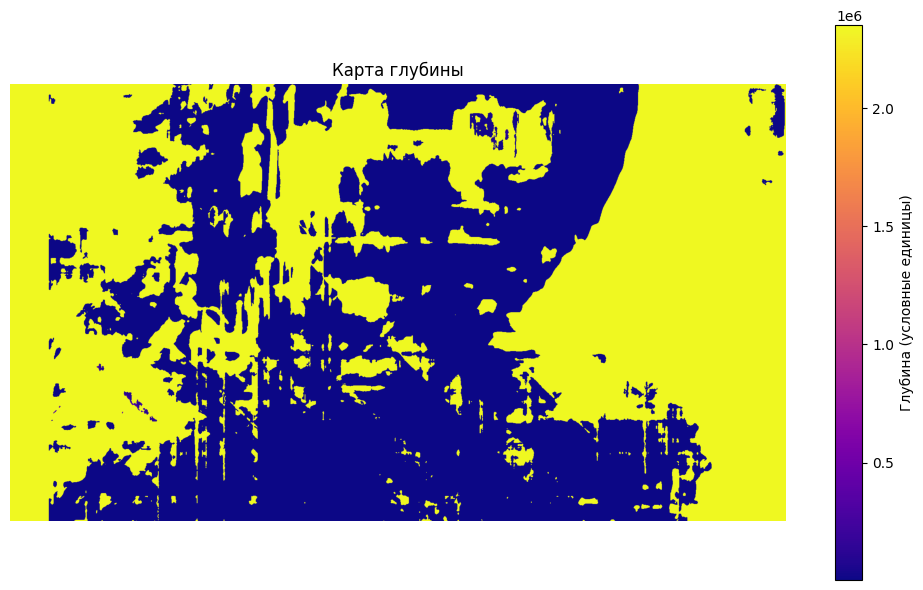

True

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Убедитесь, что depth_map загружена
# depth_map = np.load('depth_map.npy')

# Маскировка недостоверных значений (если есть)
# Например, если глубина > 1000 — считаем "недействительной"
max_valid_depth = 30000000000  # задайте порог в ваших единицах
depth_for_plot = np.where(depth_map > max_valid_depth, np.nan, depth_map)

plt.figure(figsize=(10, 6))
plt.imshow(depth_for_plot, cmap='plasma')  # 'viridis', 'inferno', 'plasma' — хорошие варианты
plt.colorbar(label='Глубина (условные единицы)')
plt.title('Карта глубины')
plt.axis('off')
plt.tight_layout()
plt.show()

# Сохранить как цветное изображение
depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
depth_colored = cv2.applyColorMap(depth_vis, cv2.COLORMAP_MAGMA)
cv2.imwrite('depth_colored.png', depth_colored)

# Или как 16-битное изображение (для точного хранения)
depth_16bit = (depth_map / depth_map.max() * 65535).astype(np.uint16)
cv2.imwrite('depth_16bit.png', depth_16bit)  # можно читать позже без потерь